In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import math
import random

import numpy as np
import pytest
import torch
import scipy.optimize
import socialforce


OPTIMIZER_OPT = {'eps': 1e-4, 'gtol': 1e-4, 'maxcor': 30, 'maxls': 10, 'disp': True}

[Sven Kreiss](https://www.svenkreiss.com), April 17 2020

# Fit PedPed Potential

In [12]:
def visualize(file_prefix, V, initial_parameters, final_parameters, fit_result=None, V_gen=None):
    b = np.linspace(0, 3, 200)
    y_ref = 2.1 * np.exp(-1.0 * b / 0.3)
    if V_gen is not None:
        y_ref = V_gen.v0 * np.exp(-1.0 * b / V_gen.sigma)

    V.set_parameters(torch.tensor(initial_parameters))
    y_initial = V.value_b(torch.from_numpy(b).float()).detach().numpy()
    y_initial -= y_initial[-1]

    if not isinstance(final_parameters, torch.Tensor):
        final_parameters = torch.tensor(final_parameters)
    V.set_parameters(final_parameters)
    y_mlp = V.value_b(torch.from_numpy(b).float()).detach().numpy()
    y_mlp -= y_mlp[-1]

    with socialforce.show.canvas(file_prefix + 'v_gradv.png', ncols=2) as (ax1, ax2):
        ax1.set_xlabel('$b$ [m]')
        ax1.set_ylabel('$V$')
        ax1.plot(b, y_ref, label=r'true $V_0 e^{-b/\sigma}$', color='C0')
        ax1.axvline(0.3, color='C0', linestyle='dotted', label=r'true $\sigma$')
        ax1.plot(b, y_initial, label=r'initial MLP($b$)',
                linestyle='dashed', color='orange')
        ax1.plot(b, y_mlp, label=r'MLP($b$)', color='orange')
        ax1.legend()

        ax2.set_xlabel(r'$b$ [m]')
        ax2.set_ylabel(r'$\nabla V$')
        delta_b = b[1:] - b[:-1]
        average_b = 0.5 * (b[:-1] + b[1:])
        ax2.plot(average_b, (y_ref[1:] - y_ref[:-1]) / delta_b,
                label=r'true $V_0 e^{-b/\sigma}$', color='C0')
        ax2.axvline(0.3, color='C0', linestyle='dotted', label=r'true $\sigma$')
        ax2.plot(average_b, (y_initial[1:] - y_initial[:-1]) / delta_b,
                label=r'initial MLP($b$)',
                linestyle='dashed', color='orange')
        ax2.plot(average_b, (y_mlp[1:] - y_mlp[:-1]) / delta_b,
                label=r'MLP($b$)', color='orange')
        ax2.set_ylim(-4.9, 0.5)
        ax2.legend()

## Generate Truth for Opposing Scenario

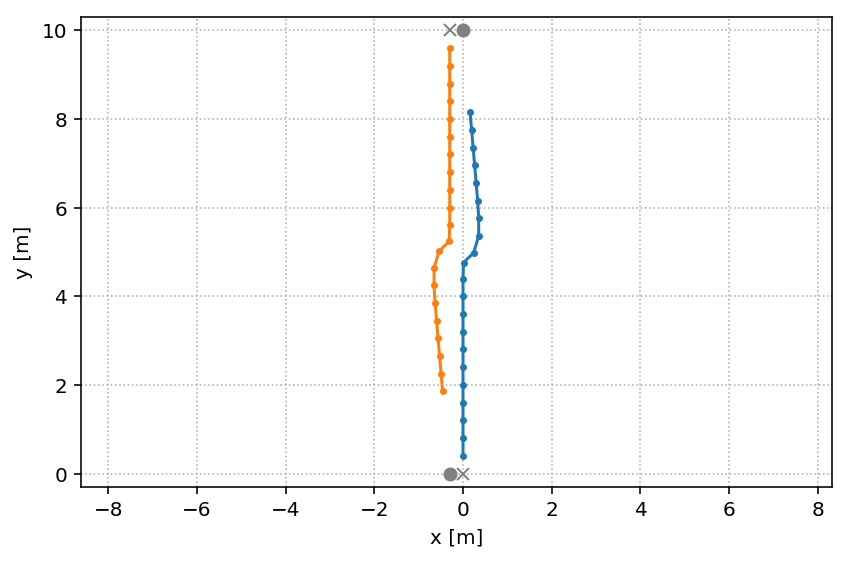

In [3]:
initial_state = [
    [0.0, 0.0, 0.0, 1.0, 0.0, 10.0],
    [-0.3, 10.0, 0.0, -1.0, -0.3, 0.0],
]
truth = socialforce.Simulator(initial_state).run(21)

with socialforce.show.track_canvas() as ax:
    socialforce.show.states(ax, truth)

## Fit a Potential with Manual Gradient Descent Implementation

In [4]:
v0 = torch.tensor(1.2, requires_grad=True)
sigma_v = torch.tensor(0.1, requires_grad=True)
V = socialforce.PedPedPotential(0.4, v0, sigma_v)

for i_update in range(100):
    generated_states = socialforce.Simulator(initial_state, ped_ped=V).run(21, detach=False)
    loss = (generated_states[1:, :, :2] - truth[1:, :, :2]).norm(dim=-1).sum()

    v0_grad, sigma_grad = torch.autograd.grad(loss, [v0, sigma_v])

    lr = 0.1 if i_update < 50 else 0.01
    with torch.no_grad():
        v0 -= lr * v0_grad
        sigma_v -= lr * sigma_grad

    print('v0', v0, v0_grad)
    print('sigma', sigma_v, sigma_grad)

assert v0.item() == pytest.approx(2.1, abs=0.01)
assert sigma_v.item() == pytest.approx(0.3, abs=0.01)

v0 tensor(1.2098, requires_grad=True) tensor(-0.0977)
sigma tensor(0.3904, requires_grad=True) tensor(-2.9039)
v0 tensor(1.2367, requires_grad=True) tensor(-0.2697)
sigma tensor(0.3663, requires_grad=True) tensor(0.2408)
v0 tensor(1.2745, requires_grad=True) tensor(-0.3781)
sigma tensor(0.4117, requires_grad=True) tensor(-0.4540)
v0 tensor(1.3006, requires_grad=True) tensor(-0.2601)
sigma tensor(0.3834, requires_grad=True) tensor(0.2829)
v0 tensor(1.3276, requires_grad=True) tensor(-0.2704)
sigma tensor(0.3617, requires_grad=True) tensor(0.2175)
v0 tensor(1.3648, requires_grad=True) tensor(-0.3719)
sigma tensor(0.4122, requires_grad=True) tensor(-0.5055)
v0 tensor(1.3905, requires_grad=True) tensor(-0.2574)
sigma tensor(0.3854, requires_grad=True) tensor(0.2687)
v0 tensor(1.4174, requires_grad=True) tensor(-0.2684)
sigma tensor(0.3650, requires_grad=True) tensor(0.2030)
v0 tensor(1.4449, requires_grad=True) tensor(-0.2752)
sigma tensor(0.3515, requires_grad=True) tensor(0.1357)
v0 tens

## Fit a Potential with Numerical Gradient Approximation with SciPy

In [7]:
def f(x):
    v0 = torch.tensor(x[0], requires_grad=True)
    sigma_v = float(x[1])
    V = socialforce.PedPedPotential(0.4, v0, sigma_v)

    generated_states = socialforce.Simulator(initial_state, ped_ped=V).run(21)
    loss = (generated_states[1:, :, :2] - truth[1:, :, :2]).norm(dim=-1).sum()

    return loss

parameters = np.array([1.2, 0.1])
res = scipy.optimize.minimize(f, parameters, method='L-BFGS-B', options=OPTIMIZER_OPT)
print(res)

assert res.x == pytest.approx(np.array([2.1, 0.3]), abs=0.01)

fun: tensor(7.3993e-05)
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.07011509, 12.0444603 ])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 183
      nit: 19
   status: 2
  success: False
        x: array([2.09991833, 0.30001818])


# Fit an MLP Potential with Numerical Gradient with SciPy

fun: tensor(0.0233)
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.90831721,  0.29532239,  0.25063753,  0.12494624, -0.19684434,
        0.01117587,  0.02168119,  0.27297065,  0.3050454 , -0.14157966,
        0.05343929,  0.14105812,  0.28904527,  0.09324402,  0.47240406])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1552
      nit: 37
   status: 2
  success: False
        x: array([-0.01141716, -0.04502965,  0.52435237,  2.25632244,  0.43702425,
       -0.03172483, -0.01427539,  0.22358885, -0.14647701, -0.03609473,
        0.90957781, -0.23494333, -0.60694374, -1.26332221,  0.30090683])


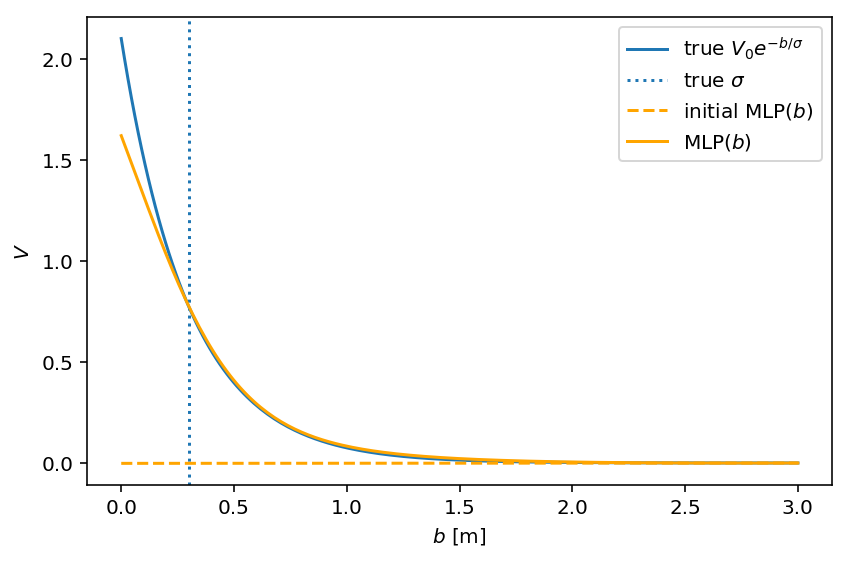

AttributeError: module 'socialforce.show' has no attribute 'graph'

In [9]:
torch.manual_seed(42)
np.random.seed(42)

V = socialforce.PedPedPotentialMLP(0.4)
parameters = V.get_parameters().clone().detach().numpy()
initial_parameters = parameters.copy()

# training
def f(x):
    V.set_parameters(torch.from_numpy(x))
    generated_states = socialforce.Simulator(initial_state, ped_ped=V).run(21)

    loss = (generated_states[1:, :, :2] - truth[1:, :, :2]).norm(dim=-1).sum()

    return loss

res = scipy.optimize.minimize(f, parameters, method='L-BFGS-B', options=OPTIMIZER_OPT)
print(res)

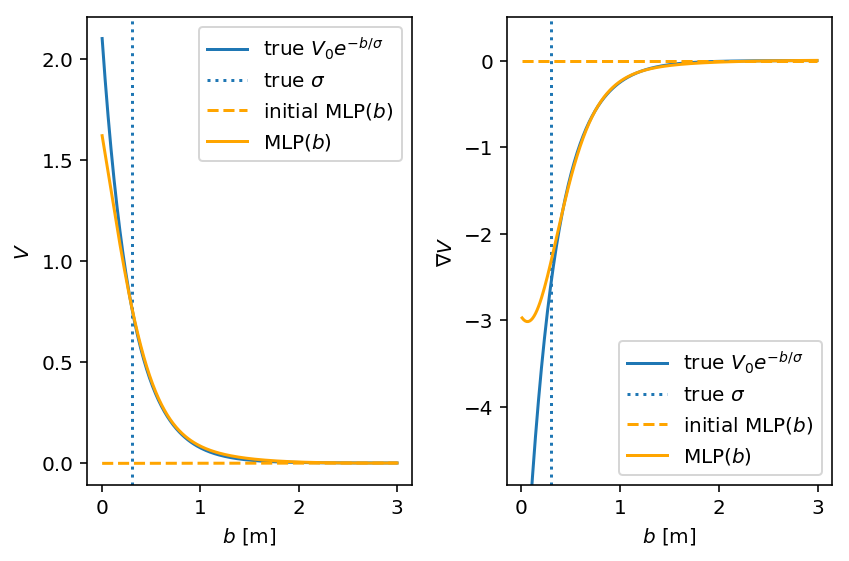

In [13]:
visualize('images/mlp_scipy_', V, initial_parameters, res.x)

## Fitting to 1, 5 and 20 Circle Scenarios each with Two Pedestrians

The preferred speed needs to be varied. Otherwise the symmetry of the problem creates unrealistic scenarios where the two pedestrians get stuck.

In [13]:
delta_t = 0.2

def generate_gt(n):
    torch.manual_seed(42)
    np.random.seed(42)

    # ped0 always left to right
    ped0 = np.array([-5.0, 0.0, 1.0, 0.0, 5.0, 0.0], dtype=np.float32)

    generator_initial_states = []
    for theta in np.random.rand(n) * 2.0 * math.pi:
        # ped1 at a random angle with +/-20% speed variation
        c, s = np.cos(theta), np.sin(theta)
        r = np.array([[c, -s], [s, c]], dtype=np.float32)
        ped1 = np.concatenate((
            np.matmul(r, ped0[0:2]),
            np.matmul(r, ped0[2:4]) * (0.8 + float(np.random.rand(1)) * 0.4),
            np.matmul(r, ped0[4:6]),
        ))
        generator_initial_states.append(
            np.stack((ped0, ped1))
        )

    generator_ped_ped = socialforce.PedPedPotential(delta_t, 2.1)
    return [
        socialforce.Simulator(initial_state, ped_ped=generator_ped_ped, delta_t=delta_t).run(42)
        for initial_state in generator_initial_states
    ]

scenarios_1 = generate_gt(1)
scenarios_5 = generate_gt(5)
scenarios_20 = generate_gt(20)

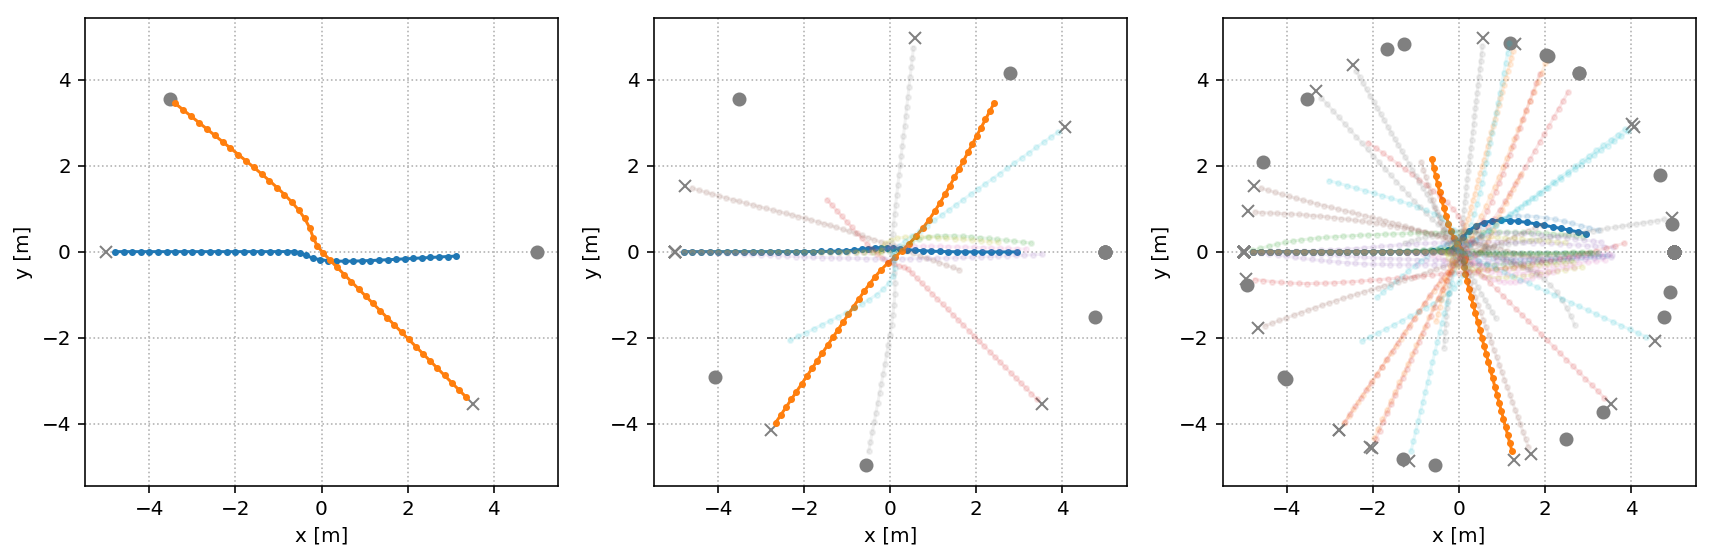

In [14]:
with socialforce.show.track_canvas(ncols=3, figsize=(12, 4)) as (ax1, ax2, ax3):
    socialforce.show.states(ax1, scenarios_1[0])

    socialforce.show.states(ax2, scenarios_5[-1])
    for scene in scenarios_5[:-1]:
        socialforce.show.states(ax2, scene, alpha=0.1)

    socialforce.show.states(ax3, scenarios_20[-1])
    for scene in scenarios_20[:-1]:
        socialforce.show.states(ax3, scene, alpha=0.1)

In [ ]:
    true_experience = socialforce.Optimizer.scenes_to_experience(true_scenes)
    V = socialforce.PedPedPotentialMLP(delta_t)
    initial_parameters = V.get_parameters().clone().detach().numpy()

    def simulator_factory(initial_state):
        s = socialforce.Simulator(initial_state, ped_ped=V, delta_t=delta_t)
        s.desired_speeds = generator.desired_speeds
        s.max_speeds = generator.max_speeds
        return s

    opt = socialforce.Optimizer(simulator_factory, V.parameters(), true_experience)
    for i in range(100 // n):
        loss = opt.epoch()
        print('epoch {}: {}'.format(i, loss))

    # make plots of result
    visualize('docs/mlp_circle_n{}_'.format(n), V, initial_parameters, V.get_parameters().clone(), V_gen=generator_ped_ped)
